In [87]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from statsmodels.stats.power import FTestAnovaPower

In [79]:
def generate_data(n_per_day, column_for_data_analysis, p1, p2, duration_days, daily = False):
    """
    Returns a pd.DataFrame with simulated CTR data
    """
    if daily is True:
        df1 = pd.DataFrame()
        df2 = pd.DataFrame()
        date_range = pd.date_range(start = '2020-01-01', periods = duration_days)
        
        for t in date_range:
            y1 = np.random.binomial(n=1, p=p1, size=n_per_day)
            y2 = np.random.binomial(n=1, p=p2, size=n_per_day) 
            dfy1 = pd.DataFrame(y1, columns=[column_for_data_analysis])
            dfy2 = pd.DataFrame(y2, columns=[column_for_data_analysis])
            dfy1['participation_timestamp_rounded_up'] = t
            dfy2['participation_timestamp_rounded_up'] = t
            df1 = pd.concat([df1, dfy1], axis =0)
            df2 = pd.concat([df2, dfy2], axis =0)
    else:
        y1 = np.random.binomial(n=1, p=p1, size = n_per_day * duration_days)
        y2 = np.random.binomial(n=1, p=p2, size = n_per_day * duration_days)
        df1 = pd.DataFrame(y1, columns=[column_for_data_analysis])
        df2 = pd.DataFrame(y2, columns=[column_for_data_analysis])
        
    df1['bucket'] = 'bucket1'
    df2['bucket'] = 'bucket2'
    df = pd.concat([df1, df2], axis = 0)
    return df

In [115]:
n_per_day = 64796
duration_days = 1
p1 = 0.05
p2 = 0.05
column_for_data_analysis = 'is_converted'
total_sample = n_per_day * duration_days
df = generate_data(n_per_day,column_for_data_analysis, p1, p2, duration_days)

In [102]:
df.groupby('bucket').sum()

,is_converted
bucket,
bucket1,3248
bucket2,3181


In [103]:
import scipy.stats as scs

def min_sample_size(bcr, mde, power, sig_level):
    """Returns the minimum sample size to set up a split test
    Arguments:
        bcr (float): probability of success for control, sometimes
        referred to as baseline conversion rate
        mde (float): minimum change in measurement between control
        group and test group if alternative hypothesis is true, sometimes
        referred to as minimum detectable effect
        power (float): probability of rejecting the null hypothesis when the
        null hypothesis is false, typically 0.8
        sig_level (float): significance level often denoted as alpha,
        typically 0.05
    Returns:
        min_N: minimum sample size (float)
    References:
        Stanford lecture on sample sizes
        http://statweb.stanford.edu/~susan/courses/s141/hopower.pdf
    """
    # standard normal distribution to determine z-values
    standard_norm = scs.norm(0, 1)

    # find Z_beta from desired power
    Z_beta = standard_norm.ppf(power)

    # find Z_alpha
    Z_alpha = standard_norm.ppf(1-sig_level/2)

    # average of probabilities from both groups
    pooled_prob = (bcr + bcr+mde) / 2

    min_N = (2 * pooled_prob * (1 - pooled_prob) * (Z_beta + Z_alpha)**2
             / mde**2)

    return int(min_N)

In [104]:
baseline_cvrs= [0.05, 0.02, 0.03]
mdes = [0.01, 0.02, 0.03, 0.05]
power = 0.85
sig_level = 0.05
ss = []
for bsc in baseline_cvrs:
    for mde in mdes:
        n = min_sample_size(bsc, mde, power, sig_level)
        ss.append((bsc, mde, n))
sample_df = pd.DataFrame(ss, columns =['baseline_cvr', 'mde', 'sample_size']) 

In [105]:
sample_df

,baseline_cvr,mde,sample_size
0,0.05,0.01,9333
1,0.05,0.02,2531
2,0.05,0.03,1212
3,0.05,0.05,498
4,0.02,0.01,4376
5,0.02,0.02,1306
6,0.02,0.03,673
7,0.02,0.05,308
8,0.03,0.01,6064
9,0.03,0.02,1723


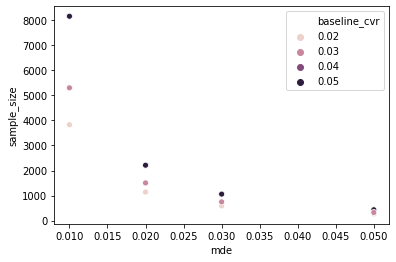

In [60]:
sns.scatterplot(x='mde', y='sample_size', hue= 'baseline_cvr',data=sample_df)

In [107]:
def calculate_cohen_f_effect_size_given_mde(
        num_groups: int, data_vector: pd.Series, mde: float
    ) -> float:
        """
        Function that takes in data and number of groups and returns Cohen's f, a standard effect size measurement for
        ANOVA testing. Cohen's f is defined as the standard deviation of the population means divided by their
        common standard deviation. FTestAnovaPower() depends on this standardized effect size as an input.
        """
        # TODO: consider bucket weights in a non-balanced bucketing situation.
        normal_mean = data_vector.mean()
        normal_std = data_vector.std()
        inflated_mean = normal_mean * (1 + mde)
        global_mean = np.mean([inflated_mean] + (num_groups - 1) * [normal_mean])
        total_group_variance = calculate_group_variance_from_global_mean(
            inflated_mean, global_mean, num_groups
        )
        for i in range(num_groups - 1):
            total_group_variance += calculate_group_variance_from_global_mean(
                normal_mean, global_mean, num_groups
            )
        total_group_std = np.sqrt(total_group_variance)
        cohens_f_effect_size = float(total_group_std / normal_std)
        return cohens_f_effect_size

In [109]:
def generate_samples_needed_for_sufficient_power(df, mde, sig_level, power):
    """
    Based on the supplied test characteristics (power, alpha, mde), calculates the expected number of participations
    needed to generate the desired power level. Calculates power assuming a one-way ANOVA analysis
    """
    num_buckets = df.bucket.nunique()
    
    standardized_effect_size = calculate_cohen_f_effect_size_given_mde(
            num_groups=num_buckets, data_vector=df[column_for_data_analysis], mde=mde
        )

    samples_needed = FTestAnovaPower().solve_power(
            effect_size=standardized_effect_size,
            alpha=sig_level,
            power=power,
            k_groups=num_buckets,
        )

    return samples_needed

In [110]:
def calculate_group_variance_from_global_mean(group_mean: float, global_mean: float, num_groups: int) -> float:
    # TODO: consider ratio as bucket weights in a non-balanced bucketing situation.
    ratio = 1 / num_groups
    return ratio * ((group_mean - global_mean) ** 2)

In [113]:
generate_samples_needed_for_sufficient_power(df, 0.02, sig_level, power)

1720041.1899876967

In [138]:
import math
ss=[]
mdes = [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]
for mde in mdes:
    n = generate_samples_needed_for_sufficient_power(df, mde, sig_level, power)
    num_days = math.ceil(n / 64796)
    ss.append((mde, n, num_days))
sample_df = pd.DataFrame(ss, columns =['mde', 'sample_size', 'duration_days']) 

In [139]:
sample_df

,mde,sample_size,duration_days
0,0.010,6.685124e+06,104
1,0.015,2.971167e+06,46
2,0.020,1.671283e+06,26
3,0.025,1.069621e+06,17
4,0.030,7.427933e+05,12
5,0.035,5.457262e+05,9
6,0.040,4.178221e+05,7
7,0.045,3.301314e+05,6
8,0.050,2.674068e+05,5


(array([-1000000.,        0.,  1000000.,  2000000.,  3000000.,  4000000.,
         5000000.,  6000000.,  7000000.,  8000000.]),
 <a list of 10 Text major ticklabel objects>)

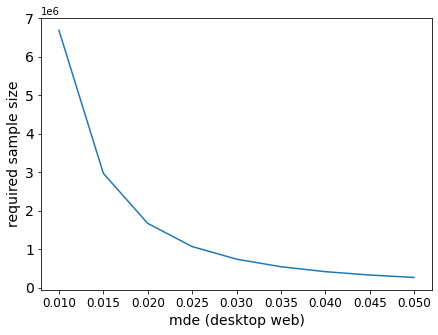

In [159]:
fig, ax = plt.subplots(figsize=(7,5))
sns.lineplot(x='mde', y='sample_size', data=sample_df)
plt.xlabel('mde (desktop web)', fontsize= 14)
plt.ylabel('required sample size', fontsize= 14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=14) 

(array([  0.,  20.,  40.,  60.,  80., 100., 120.]),
 <a list of 7 Text major ticklabel objects>)

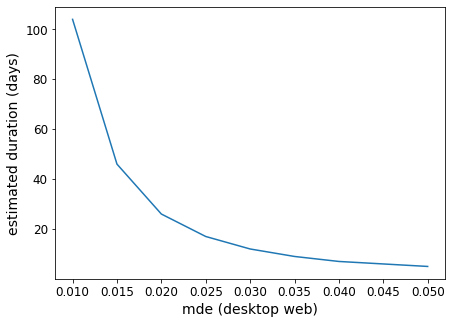

In [156]:
fig, ax = plt.subplots(figsize=(7,5))
sns.lineplot(x='mde', y='duration_days',data=sample_df)
plt.xlabel('mde (desktop web)', fontsize= 14)
plt.ylabel('estimated duration (days)', fontsize= 14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12) 